In [1]:
# https://en.wikipedia.org/wiki/Piano_key_frequencies

In [2]:
import wave
from itertools import chain

import numpy as np
from numpy import fft
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 10)

In [22]:
def key_to_freq(key):
    return np.power(2, (key-49)/12)*440

In [3]:
from numpy.lib import stride_tricks

In [4]:
data = wave.open("88-piano-keys.wav", "rb")

In [5]:
data.getparams()

_wave_params(nchannels=2, sampwidth=2, framerate=48000, nframes=33748000, comptype='NONE', compname='not compressed')

In [6]:
def pool_fast(arr, window):
    # window is odd
    view = stride_tricks.as_strided(arr, (arr.shape[0] - window + 1, window), (arr.strides[0], arr.strides[0]))
    return np.max(view, axis=1)

In [7]:
def peak_starts(raw_sample):
    sample = raw_sample.copy()
    sample[np.absolute(sample) < 25000] = 0
    sample[np.absolute(sample) >= 25000] = 1
    sample = pool_fast(sample, 10000)
    sample = sample[1:] + sample[:-1]
    peaks = np.isclose(sample, 1)
    return np.argwhere(peaks)[::2]  # ::2 to pick the beginning of the peak

In [8]:
data.rewind()

In [9]:
offset = 0

0
[[ 91759]
 [313116]
 [597014]]
[[ 91759]
 [313116]
 [597014]]


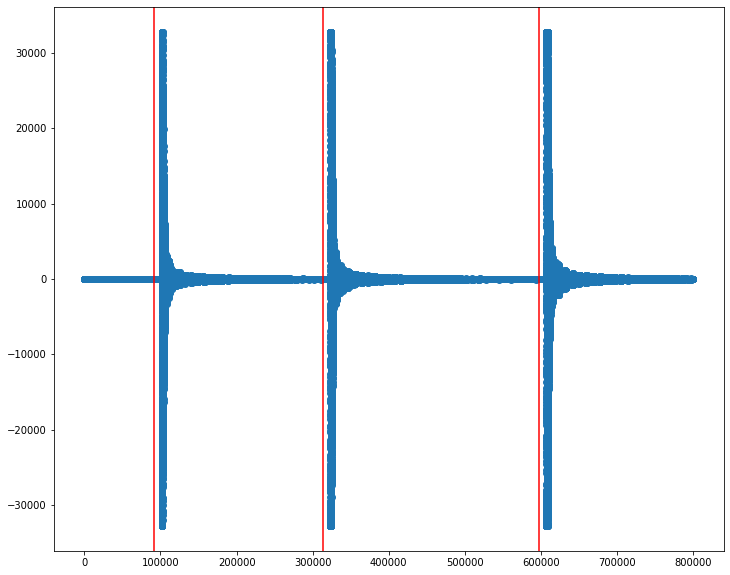

In [10]:
raw_sample = np.frombuffer(data.readframes(800000), dtype='i2')[::2]
xs = np.array(list(range(raw_sample.shape[0])))
plt.scatter(xs, raw_sample)
peaks = peak_starts(raw_sample)
print(offset)
print(peaks)
print(peaks + offset)
offset += raw_sample.shape[0]
for i in xs[peaks]:
    plt.axvline(i, color="red")

In [12]:
def all_peak_starts(data):
    data.rewind()
    offset = 0
    while True:
        bytes_sample = data.readframes(1600000)
        if not bytes_sample:
            break
        raw_sample = np.frombuffer(bytes_sample, dtype='i2')[::2]
        yield from peak_starts(raw_sample).ravel() + offset  # ::2 to choose one channel of two
        offset += raw_sample.shape[0]

In [ ]:
res = []
for i in all_peak_starts(data):
    res.append(i)
    print(i)
res = np.array(res)

In [13]:
res = np.genfromtxt("peak_locations.dat", dtype=np.int64)

In [14]:
res.shape[0]

88

In [15]:
data.rewind()

In [16]:
#offset = 28000000 - 800000
offset = 0
data.readframes(offset);

/home/vindex10/projects/venvs/sandbox/lib/python3.8/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


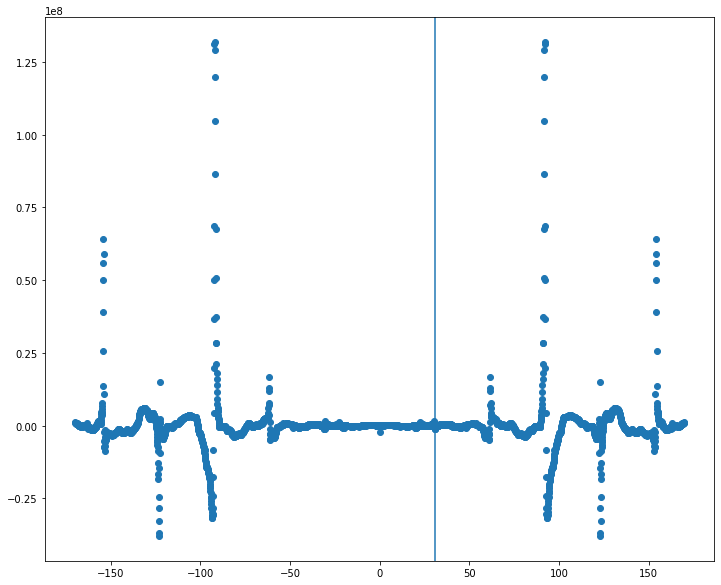

In [23]:
data.rewind()
#offset = 28000000 - 800000
offset = 32135703 + 8500
data.readframes(offset);
bytes_sample = data.readframes(32648826 - offset)
raw_sample = np.frombuffer(bytes_sample, dtype='i2')[::2]
#peaks = peak_starts(raw_sample).ravel()  # ::2 to choose one channel of two
#plt.scatter(range(raw_sample.shape[0]), raw_sample)
#peaks = res[(res <= 32648826) & (res >= offset)]
#peaks = peaks - offset
#print(peaks)
#for i in peaks:
#    plt.axvline(i, color="red")
offset += raw_sample.shape[0]
sample_fft = np.fft.fft(raw_sample)
freqs = np.fft.fftfreq(sample_fft.shape[0], d=1/data.getframerate())
base_freq = key_to_freq(3)
mask = (freqs > -base_freq*5.5) & (freqs < base_freq*5.5)
plt.scatter(freqs[mask], sample_fft[mask])
plt.axvline(base_freq)

In [24]:
offset

32648826

In [25]:
# np.savetxt("peak_locations.dat", res, fmt="%d")

In [26]:
def iter_slices(data, slices):
    data.rewind()
    n_channels = data.getnchannels()
    slices_iter = iter(slices)
    start = next(slices_iter)
    data.readframes(start)
    for end in chain(slices_iter, [data.getnframes()]):
        bytes_sample = data.readframes(end - start)
        raw_sample = np.frombuffer(bytes_sample, dtype='i2')[::n_channels]
        i_max = np.argwhere(raw_sample[raw_sample.shape[0]//2:] > 1000) + raw_sample.shape[0]//2
        if not i_max.shape[0]:
            i_max = raw_sample.shape[0]
        else:
            i_max = i_max.ravel()[0]
        i_min = np.argmax(raw_sample[:i_max])
        yield raw_sample[i_min:i_max]
        start += raw_sample.shape[0]

In [27]:
res.shape

(88,)

In [28]:
def guess_base_freq(n):
    fig_width, fig_height = plt.rcParams["figure.figsize"]
    fig, ax = plt.subplots(nrows=2, figsize=(fig_width, 2*fig_height))
    for i, sample in enumerate(iter_slices(data, res)):
        key = 88 - i
        if key != n:
            continue
        #sample = sample[:90000]
        ax[0].scatter(range(sample.shape[0]), sample)
        sample_fft = np.fft.rfft(sample)
        break
    freqs = np.fft.rfftfreq(sample.shape[0], d=1/data.getframerate())
    base_freq = key_to_freq(n)
    mask = (freqs < base_freq*5.5)
    ax[1].scatter(freqs[mask], np.absolute(sample_fft[mask]))
    ax[1].axvline(base_freq, color="red")
    ax[1].axvline(base_freq*2, color="red")
    ax[1].axvline(base_freq*3, color="red")
    ax[1].axvline(base_freq*4, color="red")

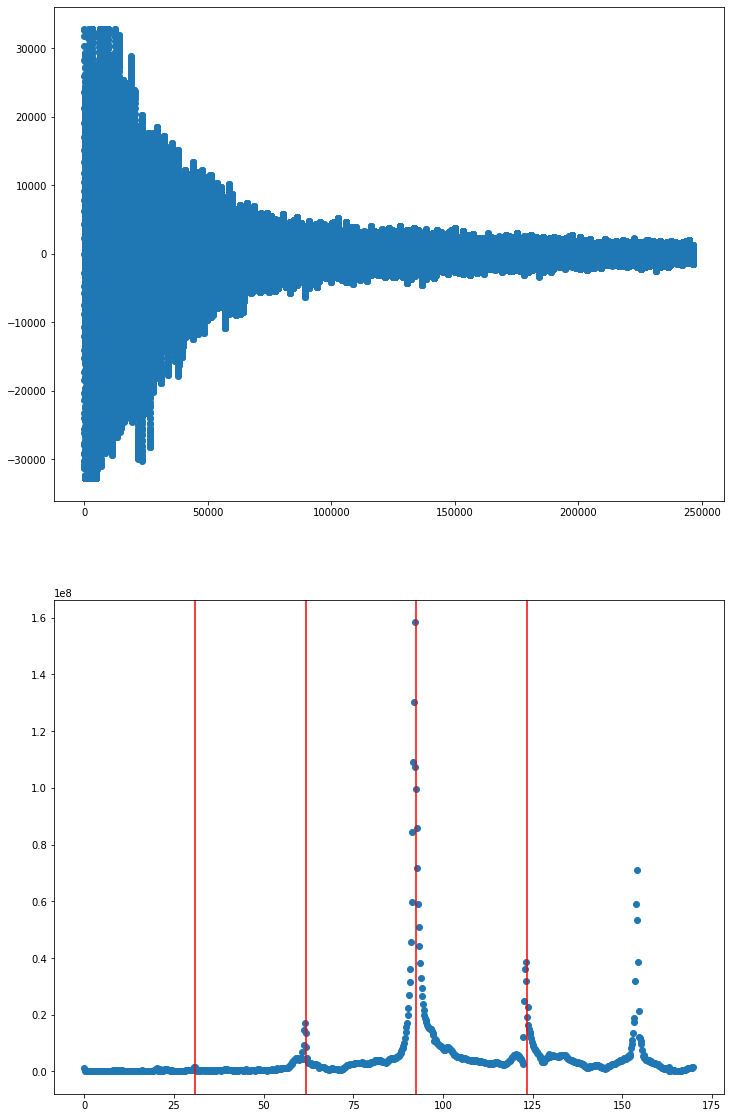

In [29]:
guess_base_freq(3)

88

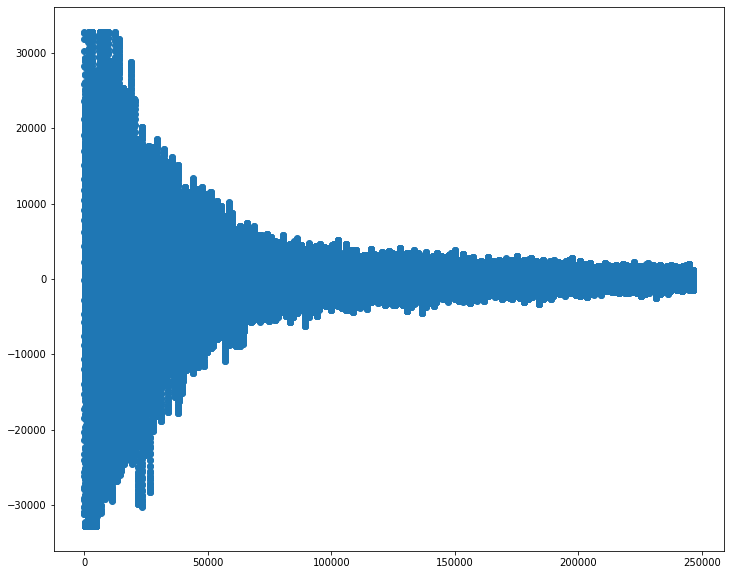

In [30]:
samples = iter(iter_slices(data, res))
i = 89
i -= 1
sample = next(samples)
while i > 3:
    i -= 1
    sample = next(samples)
plt.scatter(range(sample.shape[0]), sample)
display(88)

In [70]:
def get_amplitude(freqs, sample_fft, freq):
    window = (freqs > freq*0.95) & (freqs < freq*1.05)
    #print(np.count_nonzero(window))
    return np.absolute(sample_fft[window]).max()

def prepare_weights(data, peaks):
    num_tones = 5
    res = {}
    for i, sample in enumerate(iter_slices(data, peaks)):
        key = 88 - i
        sample_fft = np.fft.rfft(sample)
        freqs = np.fft.rfftfreq(sample.shape[0], d=1/data.getframerate())
        base_freq = key_to_freq(key)
        row = []
        for i in range(num_tones):
            row.append(get_amplitude(freqs, sample_fft, base_freq*(i+1)))
        res[key] = [i/row[0] for i in row[1:]]
    return pd.DataFrame.from_dict(res, orient="index", columns=list(range(1, num_tones))).sort_index()

In [71]:
overtone_weights = prepare_weights(data, res)

In [72]:
overtone_weights

,1,2,3,4
1,11.475179,91.833720,20.667719,41.073510
2,12.532504,57.623107,22.516754,36.442547
3,10.227994,94.821789,23.153079,42.520959
4,12.200916,83.772829,22.394292,35.099582
5,14.580342,92.361107,21.791312,47.001770
...,...,...,...,...
84,0.020132,0.019419,0.001019,0.001322
85,0.013868,0.017511,0.000958,0.001243
86,0.010902,0.030924,0.001166,0.001498
87,0.009391,0.011822,0.001175,0.002816


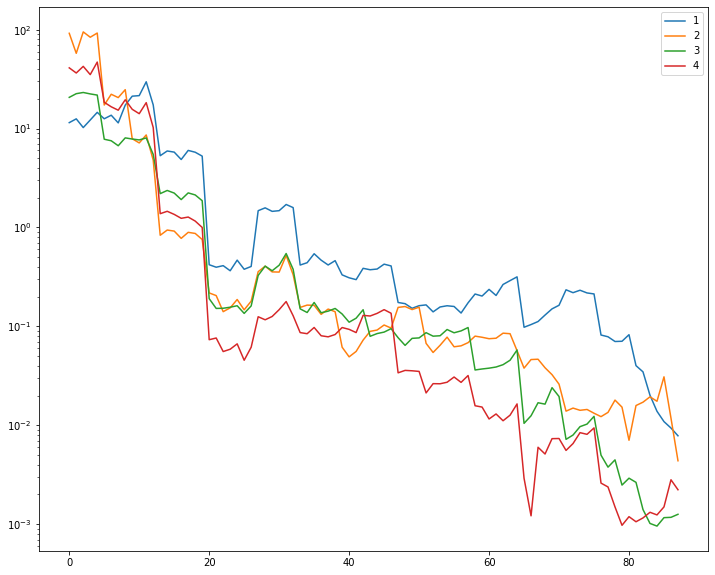

In [73]:
for i in overtone_weights.columns:
    plt.plot(range(88), overtone_weights[i], label=i)
plt.legend()
plt.yscale("log")

In [74]:
def critical_band_log(x):
    res = np.zeros_like(x)
    mask = x < 280
    res[mask] = 92
    mask = (x >= 280) & (x < 1100)
    res[mask] = 1.0008**x[mask]*76
    mask = (x >= 1100) & (x < 2600)
    res[mask] = 1.00053**x[mask]*103
    mask = x >= 2600
    res[mask] = x[mask]**1.3/70
    return res

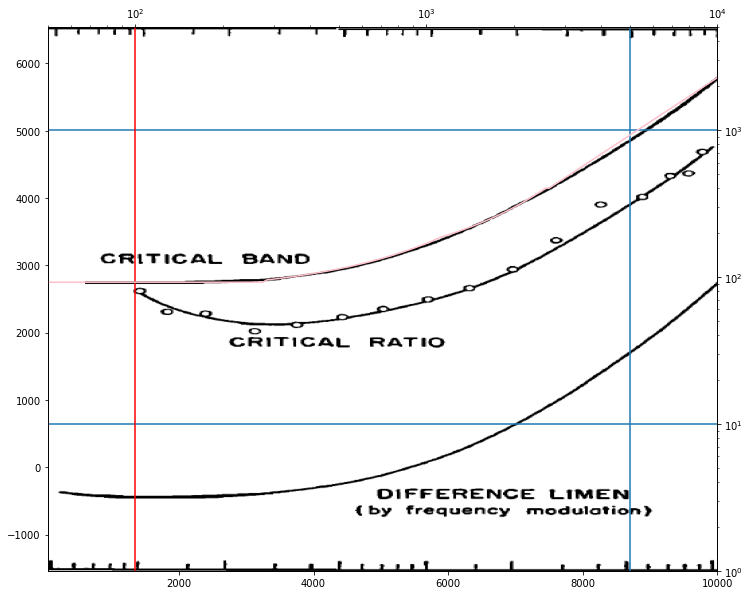

In [75]:
img = plt.imread("critical_band.png")
plt.xlim([50, 10000])
plt.ylim([1, 5000])
plt.imshow(img, extent=[-1975, 11100, -2050, 6750])
ax_y = plt.twinx()
ax_y.set_ylim([1, 5000])
ax_y.set_yscale("log")
ax_y.axhline(1000)
ax_y.axhline(10)
ax_x = plt.twiny(ax=ax_y)
ax_x.set_xlim([50, 10000])
ax_x.set_xscale("log")
ax_x.axvline(100, color="red")
ax_x.axvline(5000)
xs = np.logspace(np.log10(50), np.log10(10000), 200)
ax_x.plot(xs, critical_band_log(xs), color="pink")

In [76]:
def weight_of_freq_pair(loudest_freq, second_freq):
    consonant_interval = 1.05
    if (loudest_freq*consonant_interval > second_freq) and (loudest_freq/consonant_interval < second_freq):
        return 0
    critical_dist = critical_band_log(loudest_freq)/2
    if np.absolute(second_freq - loudest_freq) < critical_dist:
        return 1
    return 0

In [104]:
import itertools

def get_key_scores(ref_key, weights):
    ref_amplitudes = list(itertools.chain([1], weights.loc[ref_key]))
    ref_freq = key_to_freq(ref_key)
    ref_tones = [ref_freq*i for i in range(1, len(ref_amplitudes)+1)]
    res = {}
    for key, overtone_amplitudes in weights.iterrows():
        freq = key_to_freq(key)
        tones = [freq*i for i in range(1, len(overtone_amplitudes)+1)]
        amplitudes = list(itertools.chain([1], overtone_amplitudes))
        weights = []
        for (left, right) in itertools.product(range(len(ref_tones)), range(len(tones))):
            left_amp, right_amp = ref_amplitudes[left], amplitudes[right]
            louder_freq, second_freq = (ref_tones[left], tones[right]) if (left_amp > right_amp) else (tones[right], ref_tones[left])
            weights.append(np.sqrt(left_amp**2 + right_amp**2)*min(left_amp, right_amp)/max(left_amp, right_amp)*weight_of_freq_pair(louder_freq, second_freq))
            #weights.append(np.sqrt(left_amp**2 + right_amp**2)*weight_of_freq_pair(louder_freq, second_freq))
            #weights.append(weight_of_freq_pair(louder_freq, second_freq))
        res[key - ref_key] = np.sum(weights)
    return pd.DataFrame.from_dict(res, orient="index", columns=["weight"])
get_key_scores(35, overtone_weights)

,weight
-34,0.0
-33,0.0
-32,0.0
-31,0.0
-30,0.0
...,...
49,0.0
50,0.0
51,0.0
52,0.0


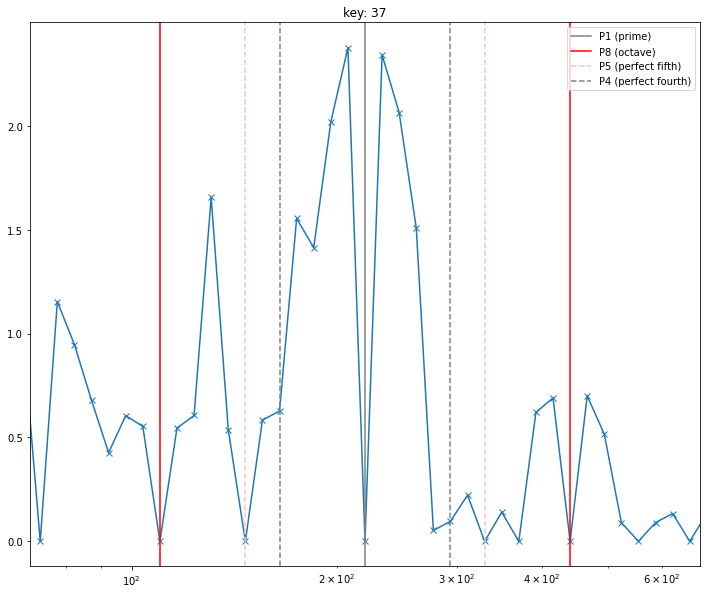

In [95]:
base = 37
weights = get_key_scores(base, overtone_weights)
plt.plot(key_to_freq(weights.index.values + base), weights["weight"].values, marker="x")
plt.xscale("log")
base_freq = key_to_freq(base)
plt.xlim([base_freq/3.1, min(base_freq*3.1, key_to_freq(88))])
plt.axvline(base_freq, label="P1 (prime)", color="gray")
plt.axvline(base_freq/2, label="P8 (octave)", color="red")
plt.axvline(base_freq*2, color="red")
plt.axvline(base_freq*3/2, ls="--", color="pink", label="P5 (perfect fifth)")
plt.axvline(base_freq*2/3, ls="--", color="pink")
plt.axvline(base_freq*4/3, ls="--", color="gray", label="P4 (perfect fourth)")
plt.axvline(base_freq*3/4, ls="--", color="gray")
plt.title(f"key: {base}")
plt.legend()

In [101]:
def get_all_scored_intervals(overtone_weights):
    res = []
    for i in overtone_weights.index.values:
        weights = get_key_scores(i, overtone_weights)
        base_loc = weights.index.get_loc(0)
        upper_weights = weights.weight.iloc[base_loc:]
        lower_weights = weights.weight.iloc[:base_loc]
        base_freq = key_to_freq(i)
        upper_intervals = np.round(np.log2(key_to_freq(i + weights.index.values[base_loc:])/base_freq)*12)
        lower_intervals = np.round(np.log2(base_freq/key_to_freq(i + weights.index.values[:base_loc]))*12)
        res.append(np.vstack([upper_intervals, upper_weights]))
        res.append(np.vstack([lower_intervals, lower_weights]))
    return np.hstack(res)

In [102]:
all_scored_intervals = get_all_scored_intervals(overtone_weights)

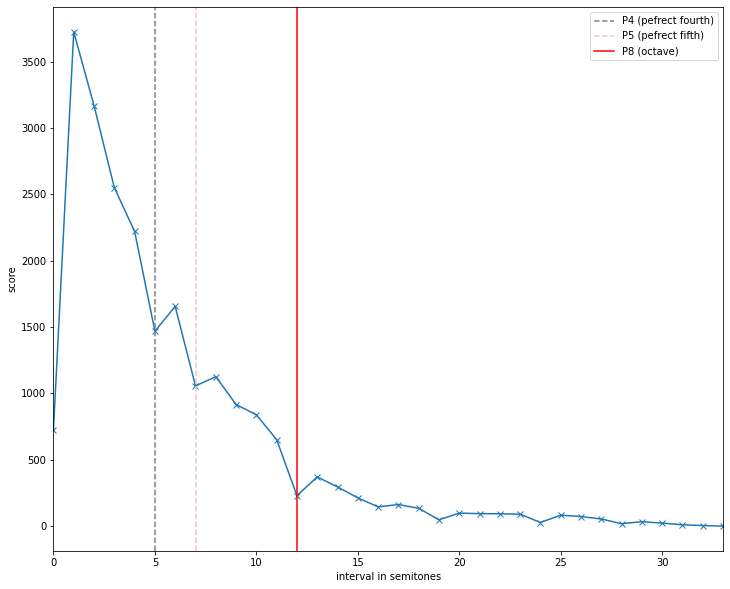

In [105]:
uniques, inverse, counts = np.unique(all_scored_intervals[0], return_inverse=True, return_counts=True)
weighted_counts = np.bincount(inverse, weights=all_scored_intervals[1])
mask = weighted_counts > 0
plt.plot(uniques, weighted_counts, marker="x")
plt.xlim([0, np.where(mask)[0][-1]+1])
plt.axvline(np.log2(4/3)*12, ls="--", color="gray", label="P4 (pefrect fourth)")
plt.axvline(np.log2(3/2)*12, ls="--", color="pink", label="P5 (pefrect fifth)")
plt.axvline(np.log2(2)*12, ls="-", color="red", label="P8 (octave)")
plt.legend()
plt.ylabel("score")
plt.xlabel("interval in semitones");